Stochastic SIR Model with testing (no removal of tested individuals from population).

Reaction - Propensity
- S+I -> 2I - beta(s,i)
- I -> R - gamma(s,i)
- S -> S + St - lambdas(s,i,r) (Implies that a susceptible and a tested susceptible behave in the same way)
- I -> I + It - lambdai(s,i,r) (" ")
- R -> R + Rt - lambdar(s,i,r) (" ")

For unbiased testing, we take

- lambdas = lambda S/(S+I+R)
- lambdai = lambda I/(S+I+R)
- lambdar = lambda R/(S+I+R)

For biased testing we take

- lambdas = lambda a1S/(a1S+a2I+a3R)
- lambdai = lambda a2I/(a1S+a2I+a3R)
- lambdar = lambda a3R/(a1S+a2I+a3R)

We may wish to vary lambda and a1,a2,a3 some "test availability" parameter.

In [1]:
import numpy as np
from numpy.random import exponential as exp
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.integrate import ode

In [28]:
#we will generate test simulations with Gillespie's algorithm
def stochastic_sir(x0,end_time,beta_fun,gamma_fun,lambda_fun,bias_fun,LambdaMax):
    s,i,r = x0
    tested_neg = 0
    tested_pos = 0
    total_pos = i
    t = 0
    t_list = [t]
    sir_list = [[s,i,r]]
    tested_neg_list = [0]
    tested_pos_list = [0]
    total_pos_list = [total_pos]
    
    while (t < end_time) or ((len(t_list))<100):
        beta = beta_fun(s,i,r,t)
        gamma = gamma_fun(s,i,r,t)
        lamb0 = beta+gamma+LambdaMax
      
        
        if lamb0:
            dt = exp(1/lamb0)
            t = t+dt 

            u  = rand()
        
            if u < beta/lamb0: #next event is infection
                s = s-1
                i = i+1 #change s,i
                sir_list += [[s,i,r]]
                total_pos += 1 #record a new (real) positive
                total_pos_list += [total_pos]
                tested_pos_list += [tested_pos]
                tested_neg_list += [tested_neg]
                t_list += [t] #update time.
            elif u < (beta + gamma)/lamb0: #next event is recovery
                i = i-1
                r = r+1 #change i,r
                sir_list += [[s,i,r]]
                total_pos_list += [total_pos] 
                tested_pos_list += [tested_pos]
                tested_neg_list += [tested_neg]
                t_list += [t] #update time.
            else: #next event is a test or nothing.
                lamb = lambda_fun(s,i,r,t,LambdaMax)
                bias = bias_fun(s,i,r,t)
                bias_N = s*bias[0] + i*bias[1] + r*bias[2]
                lambdas = lamb*bias[0]*s/bias_N
                lambdai = lamb*bias[1]*i/bias_N
                lambdar = lamb*bias[2]*r/bias_N
                if u < (beta+gamma+lambdas)/lamb0: #tested a "s"
                    tested_neg += 1
                    tested_neg_list += [tested_neg]
                    tested_pos_list += [tested_pos]
                    t_list += [t] #update time.
                    sir_list += [[s,i,r]]
                    total_pos_list += [total_pos] 
                elif u < (beta+gamma+lambdas+lambdai)/lamb0: #tested a "i"
                    tested_pos += 1
                    tested_pos_list += [tested_pos]
                    tested_neg_list += [tested_neg]
                    t_list += [t] #update time.
                    sir_list += [[s,i,r]]
                    total_pos_list += [total_pos]
                elif u < (beta+gamma+lambdas+lambdai+lambdar)/lamb0: #tested a "r"
                    tested_neg += 1
                    tested_neg_list += [tested_neg]
                    tested_pos_list += [tested_pos]
                    t_list += [t] #update time.
                    sir_list += [[s,i,r]]
                    total_pos_list += [total_pos]
                
                
        else:
            break
        
    return (np.array(t_list), np.array(sir_list), np.array(total_pos_list)), (np.array(t_list),np.array(tested_neg_list),np.array(tested_pos_list))



In [488]:
N = 200
LambdaMax = 10

init_inf = 0.01
izero = int(init_inf*N)
szero = N-izero

R0 = 3

In [73]:
def Beta(s,i,r,t):
    return (R0)*s*i/(s+i+r)
def Gamma(s,i,r,t):
    return i
def Lamb(s,i,r,t,LM):
    return LM#*t/(1+t)
def Bias(s,i,r,t):
    return [1,1,1]

In [39]:
infection,testing = stochastic_sir([szero,izero,0],15,Beta,Gamma,Lamb,Bias,LambdaMax)

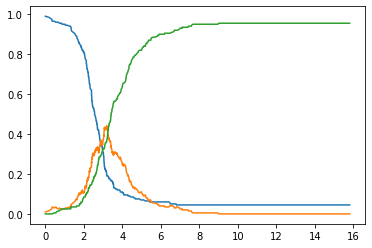

In [40]:
plt.plot(infection[0],infection[1]/N)

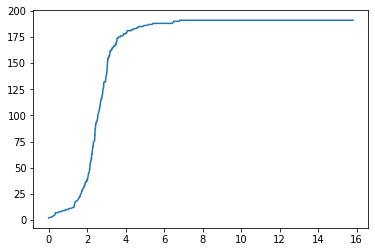

In [41]:
plt.plot(infection[0],infection[2])

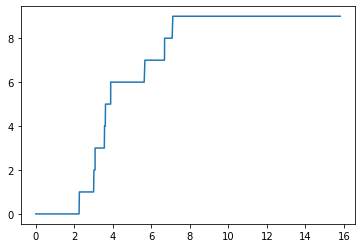

In [42]:
plt.plot(testing[0],testing[2])

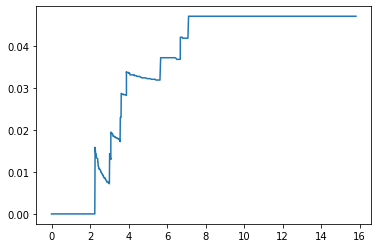

In [43]:
plt.plot(testing[0],testing[2]/infection[2])

In [44]:
np.max(testing[2]/infection[2])

0.04712041884816754

Below, we have the non-dimensionalized deterministic SIR model.

In [45]:
def SIR_model_rescaled(t,X,params):
    R0 = params
    s,i,r= X
    dsdt = -R0*s*i
    didt = -dsdt - i
    drdt = i
    return [dsdt,didt,drdt]

In [402]:
s0 = (1-init_inf)
i0 = init_inf
r0 = 0

t0 = 0 
end_time = 50
tst = 0.01

R0 = 1.36

sir_sol = ode(SIR_model_rescaled)
sir_sol.set_f_params(np.array([R0]))
sir_sol.set_initial_value([s0,i0,r0],0)

time_array = np.array([t0])
sol_list = [[s0,i0,r0]]
for tpt in np.arange(t0,end_time,tst):
    s,i,r = sir_sol.integrate(sir_sol.t + tst)
    sol_list = sol_list + [[s,i,r]]
    time_array = np.append(time_array,sir_sol.t)
sol_array = np.array(sol_list)
sim_length = len(sol_array)

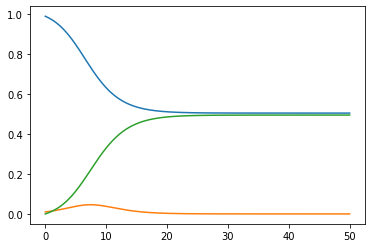

In [403]:
plt.plot(time_array,sol_array.T[0],time_array,sol_array.T[1],time_array,sol_array.T[2])

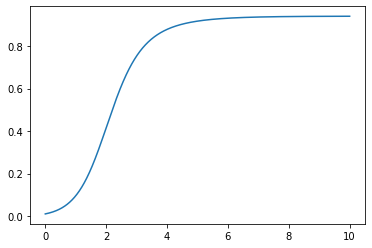

In [54]:
plt.plot(time_array,s0-sol_array.T[0] + i0)

We can model stochastic sampling of the deterministic model. Because we have propensities that sum to lambda, we this is (relatively) easy if lambda is constant. If lambda is not constant, we can still compute without much difficulty as long as we have a relatively tight upper bound on lambda. We'll call this lambdaMax.

Below, we compute the trajectory as well as counting sampling.

In [368]:
N = 20000
LambdaMax = 300

In [371]:
def sample_traj(x0,t0,end_time,dynamics,dynamics_params,lambdafun,biasfun,LambdaMax):
    
    #dynamics should model susceptible, infected, recovered. (for now)

    s0,i0,r0 = x0

    odemod = ode(dynamics)
    odemod.set_f_params(dynamics_params)
    odemod.set_initial_value([s0,i0,r0],0)
    
    tot_cases = [i0]
    infected = [i0]

    time_array = np.array([t0])
    st,it,rt = [0,0,0]
    test_list = [[st,it,rt]]
    t = 0
    
    while odemod.successful and odemod.t < end_time:
        dt = exp(1/LambdaMax)
        s,i,r = odemod.integrate(odemod.t + dt)
        lamb = lambdafun(s,i,r,odemod.t,LambdaMax)
        bias = biasfun(s,i,r,odemod.t)
        bias_N = s*bias[0] + i*bias[1] + r*bias[2]
        lambdas = lamb*bias[0]*s/bias_N
        lambdai = lamb*bias[1]*i/bias_N
        lambdar = lamb*bias[2]*r/bias_N
        u = LambdaMax*rand()
        if u < lambdas: #tested a "s"
            st += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]
            infected += [i]
        elif u < (lambdas + lambdai): #tested a "i"
            it += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]
            infected += [i]
        elif u < (lambdas + lambdai + lambdar): #tested a "r"
            rt += 1
            test_list += [[st,it,rt]]
            time_array = np.append(time_array,odemod.t)
            tot_cases += [s0-s+i0]
            infected += [i]

    return time_array,np.array(test_list),np.array(tot_cases),infected
            


        

In [154]:
def Lamb(s,i,r,t,LM):
    return LM*t/(1+t)

In [185]:
def Lamb(s,i,r,t,LM):
    return LM

In [179]:
def Bias(s,i,r,t):
    if t > 1:
        return [1,1 + 0.3*(1/t),1]
    else:
        return [1,1.3,1]

In [378]:
def Bias(s,i,r,t):
    return [1,5,1]

In [489]:
t,tests,cases,active_cases = sample_traj([s0,i0,r0],0,10,SIR_model_rescaled,np.array([R0]),Lamb,Bias,LambdaMax)

Text(0.5, 1.0, 'Biased testing, decaying bias, max alpha2=1.3, L = 300, N = 20000')

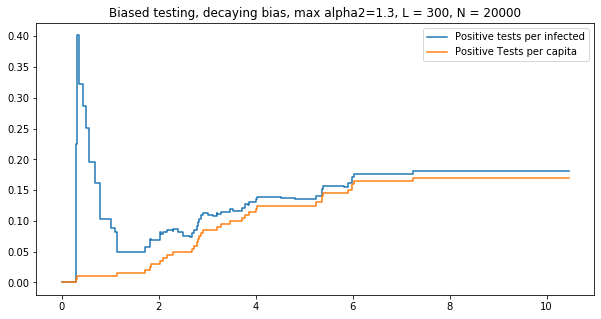

In [490]:
fig,ax = plt.subplots(figsize = (10,5))
ax.step(t,tests.T[1]/(N*cases),label = "Positive tests per infected")
ax.step(t,tests.T[1]/N, label = "Positive Tests per capita")
ax.legend()
ax.set_title("Biased testing, decaying bias, max alpha2=1.3, L = 300, N = 20000")
# fig.savefig("biased_decay")

/Users/m197894/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


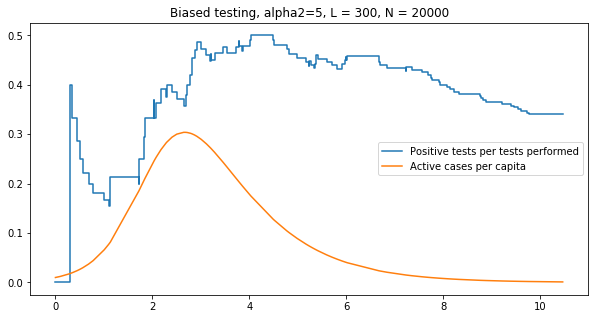

In [499]:
fig,ax = plt.subplots(figsize = (10,5))
ax.step(t,tests.T[1]/(tests.T[0] + tests.T[1] + tests.T[2]),label = "Positive tests per tests performed")
ax.plot(t,active_cases, label = "Active cases per capita")
ax.legend()
ax.set_title("Biased testing, alpha2=5, L = 300, N = 20000")
fig.savefig("biased_decay_stoch_pertest")

If we have unbiased sampling and constant Lambda, this will approach Lambda/N. If the bias is small enough, this will approach the product of the bias and lambda.

In [87]:
np.max(tests.T[1]/(N*cases))

0.05680991799799414

Below, let's do deterministic biased sampling.

In [295]:
def SIR_model_withsampling(t,X,params):
    R0,biasfun,lam0 = params
    s,i,r,iT= X
    dsdt = -R0*s*i
    didt = -dsdt - i
    drdt = i
    bias = biasfun(s,i,r,t)
    diTdt = lam0*bias[1]*i/(bias[0]*s + bias[1]*i + bias[2]*r)
    return [dsdt,didt,drdt,diTdt]

In [418]:
a2 = 1
def Bias(s,i,r,t):
    return [1,a2,1]

In [419]:
s0 = (1-init_inf)
i0 = init_inf
r0 = 0

lam0 = LambdaMax/N

t0 = 0 
end_time = 30
tst = 0.01

sir_sol = ode(SIR_model_withsampling)
sir_sol.set_f_params([R0,Bias,lam0])
sir_sol.set_initial_value([s0,i0,r0,0],0)

time_array = np.array([t0])
sol_list = [[s0,i0,r0,0]]
for tpt in np.arange(t0,end_time,tst):
    s,i,r,iT = sir_sol.integrate(sir_sol.t + tst)
    sol_list = sol_list + [[s,i,r,iT]]
    time_array = np.append(time_array,sir_sol.t)
sol_array = np.array(sol_list)
sim_length = len(sol_array)

In [420]:
cases = s0-sol_array.T[0] + i0

Text(0.5, 1.0, 'Biased Testing, Lambda0 = 0.05')

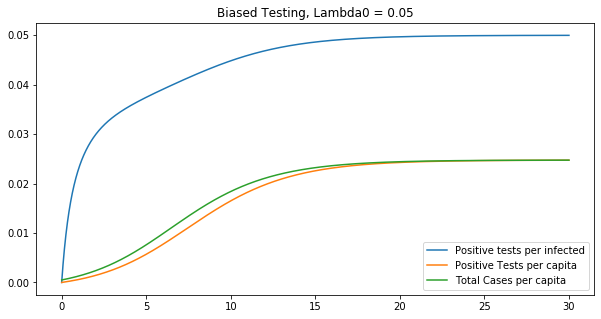

In [421]:
fig,ax = plt.subplots(figsize = (10,5))
ax.plot(time_array,sol_array[:,3]/(cases),label = "Positive tests per infected")
ax.plot(time_array,sol_array[:,3], label = "Positive Tests per capita")
ax.plot(time_array,lam0*cases, label = "Total Cases per capita")

ax.legend()
ax.set_title("Biased Testing, Lambda0 = " + str(lam0))
# fig.savefig("unbiased_det")

In [422]:
tests_performed = lam0*time_array

/Users/m197894/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Unbiased Testing, Lambda0 = 0.05 alpha 2 = 1')

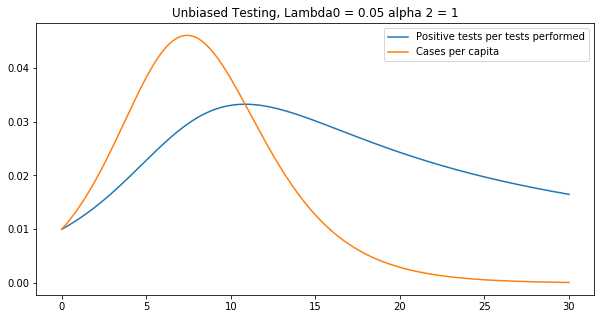

In [423]:
fig,ax = plt.subplots(figsize = (10,5))
ax.plot(time_array,sol_array[:,3]/(tests_performed),label = "Positive tests per tests performed")
ax.plot(time_array,sol_array.T[1], label = "Cases per capita")

ax.legend()
ax.set_title("Unbiased Testing, Lambda0 = " + str(lam0) + " alpha 2 = " +str(a2))
# fig.savefig("unbiased_det_pertest"+str(a2))

/Users/m197894/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/m197894/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


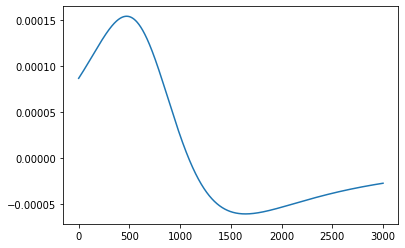

In [424]:
bias = [1,a2,1]
weighted_frac = lam0*bias[1]*sol_array.T[1]/(bias[0]*sol_array.T[0] + bias[1]*sol_array.T[1] + bias[2]*sol_array.T[2])
pos_rate = weighted_frac/time_array - sol_array.T[3]/time_array**2
plt.plot(pos_rate)

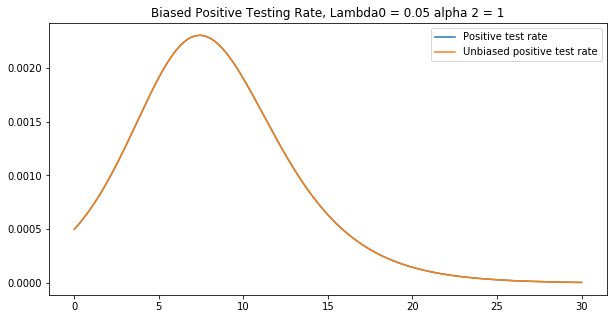

In [425]:
fig,ax = plt.subplots(figsize = (10,5))
ax.plot(time_array,weighted_frac,label = "Positive test rate")
ax.plot(time_array,lam0*sol_array.T[1], label = "Unbiased positive test rate")

ax.legend()
ax.set_title("Biased Positive Testing Rate, Lambda0 = " + str(lam0) + " alpha 2 = " +str(a2))
fig.savefig("unbiased_det_pertime"+str(a2))

Text(0.5, 1.0, 'Biased Positive Testing Rate, Lambda0 = 0.015 alpha 2 = 5')

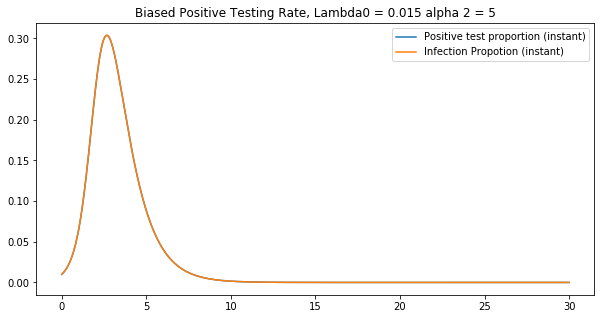

In [495]:
weighted_frac = bias[1]*sol_array.T[1]/(bias[0]*sol_array.T[0] + bias[1]*sol_array.T[1] + bias[2]*sol_array.T[2])

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(time_array,weighted_frac,label = "Positive test proportion (instant)")
ax.plot(time_array,sol_array.T[1], label = "Infection Propotion (instant)")

ax.legend()
ax.set_title("Biased Positive Testing Rate, Lambda0 = " + str(lam0) + " alpha 2 = " +str(a2))

In [493]:
weighted_frac

array([1.00000000e-02, 1.01989075e-02, 1.04016770e-02, ...,
       1.09318683e-10, 1.08392196e-10, 1.07473340e-10])

In [453]:
a2 = 5
R0 = 3
N = 20000
LambdaMax = 300


init_inf = 0.01

def SIR_model_withsampling(t,X,params):
    R0,bias,lam0 = params
    s,i,r,iT= X
    dsdt = -R0*s*i
    didt = -dsdt - i
    drdt = i
    diTdt = lam0*bias[1]*i/(bias[0]*s + bias[1]*i + bias[2]*r)
    return [dsdt,didt,drdt,diTdt]

def peak_ratio(a2,R0,N,LambdaMax,init_inf):

    s0 = (1-init_inf)
    i0 = init_inf
    r0 = 0

    lam0 = LambdaMax/N

    t0 = 0 
    end_time = 30
    tst = 0.01

    sir_sol = ode(SIR_model_withsampling)
    sir_sol.set_f_params([R0,[1,a2,1],lam0])
    sir_sol.set_initial_value([s0,i0,r0,0],0)

    time_array = np.array([t0])
    sol_list = [[s0,i0,r0,0]]
    for tpt in np.arange(t0,end_time,tst):
        s,i,r,iT = sir_sol.integrate(sir_sol.t + tst)
        sol_list = sol_list + [[s,i,r,iT]]
        time_array = np.append(time_array,sir_sol.t)
    sol_array = np.array(sol_list)
    sim_length = len(sol_array)
    tests_performed = lam0*time_array

    return max(sol_array[1:,3]/(tests_performed[1:]))/max(sol_array.T[1])

In [454]:
peak_ratio(3,R0,N,LambdaMax,init_inf)

1.1893912299458487

In [456]:
ratios = [peak_ratio(a,R0,N,LambdaMax,init_inf) for a in np.arange(1,5,0.1)]

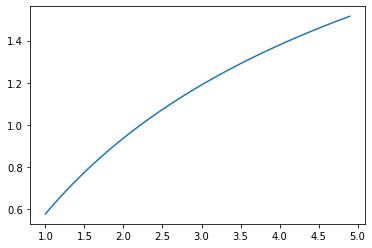

In [457]:
plt.plot(np.arange(1,5,0.1),ratios)

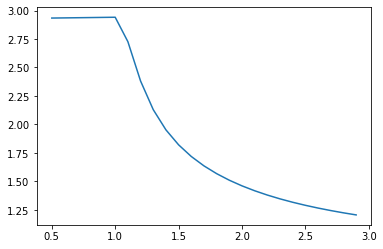

In [459]:
ratios2 = [peak_ratio(3,r,N,LambdaMax,init_inf) for r in np.arange(0.5,3,0.1)]
plt.plot(np.arange(0.5,3,0.1),ratios2)

In [473]:

all_ratios =np.array([[peak_ratio(a,r,N,LambdaMax,init_inf) for r in np.arange(1,5,.1)]for a in np.arange(1,5,.1)])

Text(0.5, 0, 'Bias')

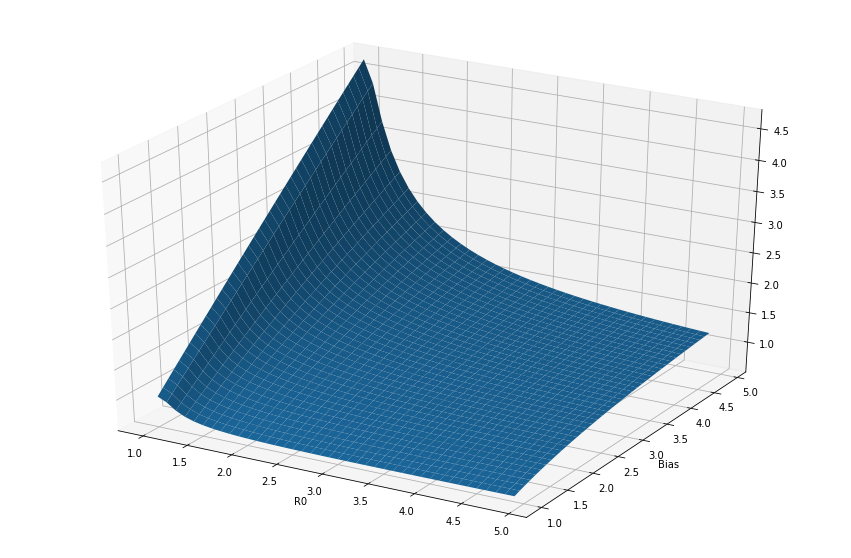

In [480]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (15,10))
ax = plt.axes(projection='3d')
X = np.arange(1,5,.1)
Y = np.arange(1,5,.1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X,Y,all_ratios)
ax.set_xlabel("R0")
ax.set_ylabel("Bias")

In [465]:
X

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [466]:
Y

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

In [498]:
np.maximum(1,np.array([0,0,2]))

array([1, 1, 2])

In [500]:
callable(Bias)

True

In [4]:
a = np.random.rand(9,3)

In [5]:
a

array([[0.88635372, 0.76091665, 0.07338184],
       [0.07135261, 0.01958675, 0.48681913],
       [0.5533717 , 0.46523789, 0.5626593 ],
       [0.75062155, 0.10153135, 0.31592983],
       [0.16547938, 0.98406887, 0.43049656],
       [0.24746842, 0.34792737, 0.52247526],
       [0.49381446, 0.82348916, 0.75227001],
       [0.2223988 , 0.00854681, 0.04258508],
       [0.51417503, 0.9304085 , 0.01709592]])

In [13]:
np.sum(a[:,[1,2]],axis = 1)

array([0.83429848, 0.50640589, 1.02789719, 0.41746119, 1.41456544,
       0.87040263, 1.57575917, 0.05113189, 0.94750442])

In [11]:
a[:,[1]]

array([[0.76091665],
       [0.01958675],
       [0.46523789],
       [0.10153135],
       [0.98406887],
       [0.34792737],
       [0.82348916],
       [0.00854681],
       [0.9304085 ]])

In [17]:
isinstance(np.array([1]),list)

False

In [20]:
np.isscalar([1])

False

In [26]:
np.argwhere(np.array([1.0,2.0,3.4]) > 1.0)[0,0]

1

In [28]:
b = np.random.rand(10)

In [29]:
b

array([0.39673473, 0.24887723, 0.03421011, 0.52946609, 0.57223985,
       0.70058346, 0.67173548, 0.9463662 , 0.61048281, 0.4297166 ])

In [32]:
np.argmax(b)

7